source file for the documentation in the [jupyter notebook `GlassOfWater.ipynb`](GlassOfWater.ipynb) and converted to markdown by `jupyter nbconvert`.

Sloshing in a Glass of Water
======================

This example demostrates the coupling between solid mechanics (`<mechanic>` PDE) and free surface water waves (`<waterWave>` PDE).
For details of the governing equations refer to our publication[^1].
Them mesh is generated with cubit using the [GlassOfWater.jou](GlassOfWater.jou), which produces the mesh `GlassOfWater.cdb`.

![mesh](mesh.png)

The material file [mat.xml](mat.xml) defines the material properties.

Sloshing modes of the Water Volume
-----------------------------------------------------

We define an Eigenfrequency annalysis to compute the sloshing modes in the XML input [WaterModes.xml](WaterModes.xml).
Run the simulation by executing
```
cfs WaterModes
```

The modes are then visualised in ParaView (use the state file [WaterModes.pvsm](WaterModes.pvsm)).
You can use paraviews _export animation_ function to export the modes.
The computed modes are plotted here in the following using python.

First we import matplotlib and set some options

In [1]:
%matplotlib inline 
# import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
from cycler import cycler
color_cycle = cycler('color',['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999','#ffff33'])
mpl.rc('figure',figsize=[2.7,1.6]) # figure size in inch
mpl.rc('figure',dpi=200) # inline dpi (=display size in browser)
mpl.rc('font',size=8.0)
#mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rc('lines',linewidth=0.7) 
mpl.rc('axes',prop_cycle=color_cycle,grid=True,linewidth=0.5,axisbelow=True,unicode_minus=False)
mpl.rc('grid',linewidth=0.3,linestyle=':')
mpl.rc('legend',fontsize='medium',framealpha=1.0,numpoints=1)
mpl.rc('svg',fonttype='none')
mpl.rc('savefig',dpi=300)

Then we import some helper functions from CFS (see source code) to acess the result files.
We read the computed natural frequencies (step values in Hz):

In [2]:
# import cfs tools
from sys import path
path.append('/home/ftoth/openCFS/CFS/share/python/')
from hdf5_tools import *
f_eigen = get_step_values('results_hdf5/WaterModes.cfs')[0]
f_eigen[1:]

array([3.58408981, 3.58408981, 4.64634551, 4.646351  , 5.31460203,
       5.46617982, 5.46617982, 6.16236872, 6.16237406, 6.2881556 ,
       6.2881556 , 6.77986437, 6.77986437, 7.06106289, 7.06137654,
       7.23091523, 7.34199178, 7.34200377, 7.72717791, 7.72717791,
       7.86312303, 7.86312303, 7.989072  , 7.989072  , 8.32375798,
       8.32404929, 8.35316041, 8.35321557, 8.64515051])

Finally we plot the first few modes

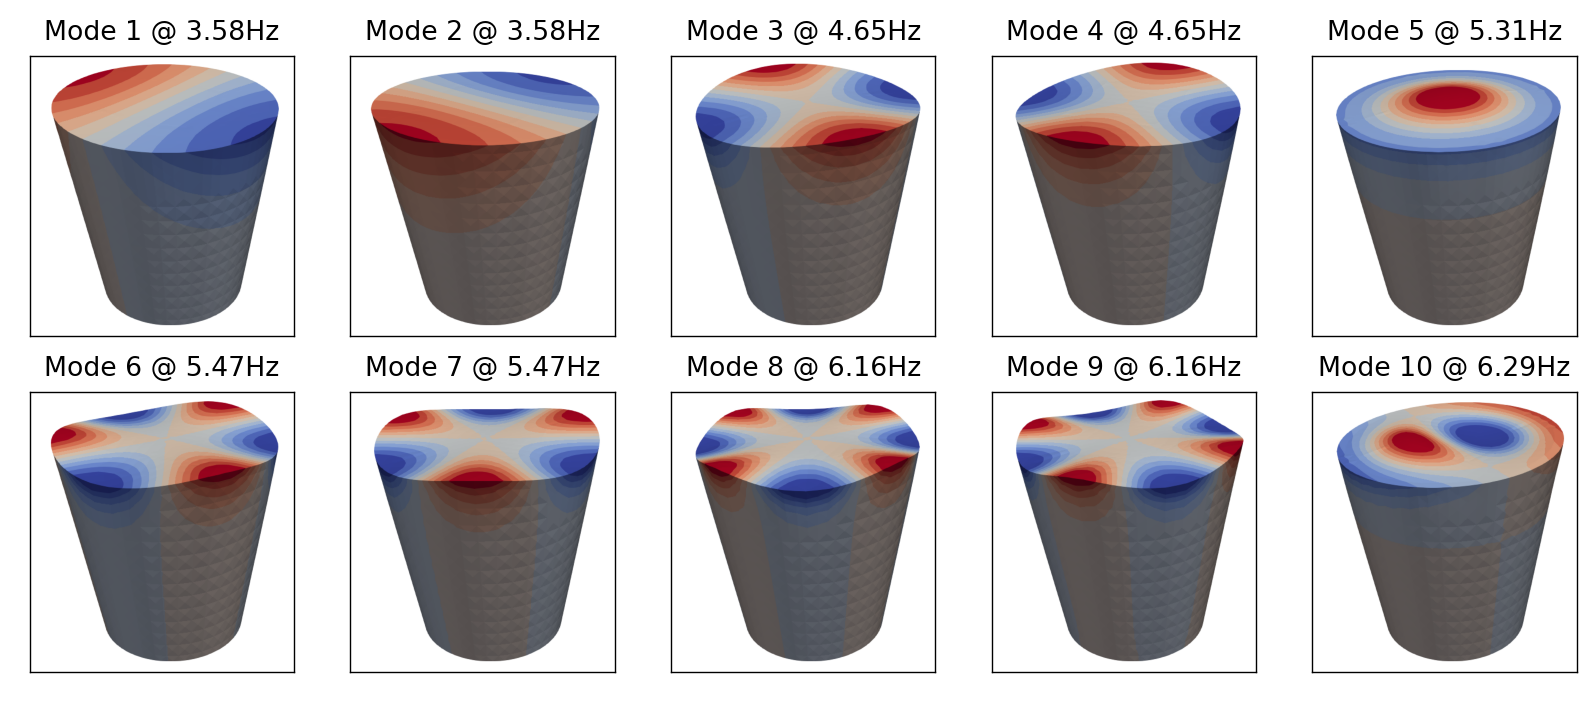

In [3]:
fig, axs = plt.subplots(ncols=5,nrows=2,figsize=[10,4])
for i in range(1,len(axs.ravel())+1):
    ax = axs.ravel()[i-1]
    img = plt.imread("WaterModes_%02i.png"%(i))
    ax.imshow(img)
    ax.set_xlim(150,650)
    ax.set_ylim(550,20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Mode %i @ %0.2fHz"%(i,f_eigen[i]))

Forced Slosing
----------------------

We compute forced slosing by coupling the water domain (`V_water`) and a stiff glass container (`V_glass`) at the common interface (`S_glass-water-bottom` and `S_glass-water-wall`).
On the bottom of the container (`S_glass-bottom`) we prescribe a harmonic displacement.

### Sway
The XML input for this case is [`Forced_Sway.xml`](Forced_Sway.xml).

We load the pressure data (in the fluid) in and plot the maximum pressure (proportional to the surface elevation).
There are peaks at some natural frequencies (all marked by vertical lines).
The peaks mark the modes wich are excited by the sway motion.

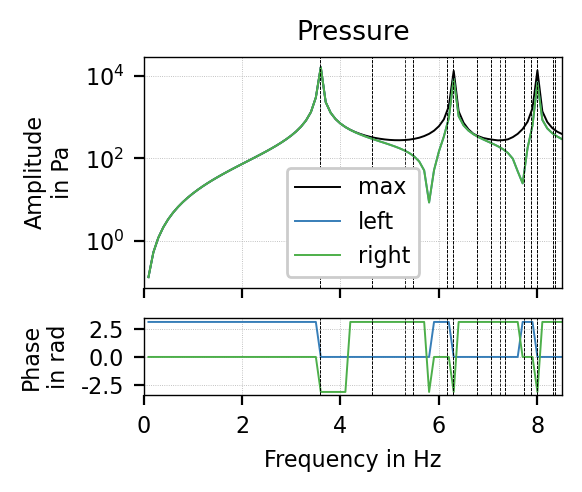

In [4]:
h5 = 'results_hdf5/Forced_Sway.cfs'
P = get_result(h5,'waterPressure',step='all')
f = get_step_values(h5)[0]

I_surface = get_subregion_idx(h5,'V_water','S_surface')
f = get_step_values(h5)[0]

X = get_coordinates(h5,'V_water')
I_left = np.argmin(np.linalg.norm(np.abs(X - np.array([X[:,0].min(),0,X[:,2].max()])),axis=1)).ravel() # indices of the surface points with y = 0
I_right = np.argmin(np.linalg.norm(np.abs(X - np.array([X[:,0].max(),0,X[:,2].max()])),axis=1)).ravel() # indices of the surface points with y = 0


fig,axs=plt.subplots(nrows=2,figsize=[2.7,2.2], gridspec_kw={'height_ratios': [3, 1]})
ax = axs[0]
ax.semilogy(f,np.max(np.abs(P[:,I_surface]),axis=1),'k',label='max' )
ax.semilogy(f,np.abs(P[:,I_left]),label='left' )
ax.semilogy(f,np.abs(P[:,I_right]),label='right' )
#ax.semilogy(f,np.abs(np.mean(P[:,I_surfleft],axis=1)),label='surfleft' )

ax.set_ylabel('Amplitude\nin Pa')
ax.set_title('Pressure')

ax = axs[1]
ax.plot(f,np.angle(P[:,I_left]),label='left' )
ax.plot(f,np.angle(P[:,I_right]),label='right' )
ax.set_ylabel('Phase\nin rad')


axs[-1].set_xlabel('Frequency in Hz')
axs[0].legend()
axs[0].set_xticklabels([])

#ax.set_ylim(ax.get_ylim())
for ax in axs:
    ax.set_xlim(0,f[-1])
    lim = ax.get_ylim()
    ax.set_ylim(lim)
    ax.vlines(f_eigen,*lim,lw=0.3,color='k',ls='--');

We can also export an animation of the forced oscillation in Paraview.
See the state file [Forced_Sway_animation.pvsm](Forced_Sway_animation.pvsm).
Coose to save PNG files and then convert them into an animated gif using imagemagic `convert -delay 10 -loop 0 forced-sway-6.5Hz.*.png forced-sway-6.5Hz.gif`:
![Animation at 6.5Hz](forced-sway-6.5Hz.gif)

### Pitch
The XML input for this case is [`Forced_Pitch.xml`](Forced_Pitch.xml).

We load the pressure data (in the fluid) in and plot the maximum pressure (proportional to the surface elevation).
There are peaks at some natural frequencies (all marked by vertical lines).
The peaks mark the modes wich are excited by the sway motion.

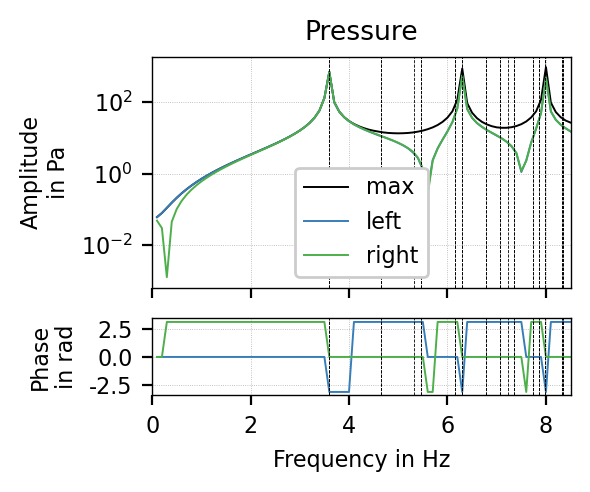

In [5]:
h5 = 'results_hdf5/Forced_Pitch.cfs'
P = get_result(h5,'waterPressure',step='all')
I_surface = get_subregion_idx(h5,'V_water','S_surface')
f = get_step_values(h5)[0]

X = get_coordinates(h5,'V_water')
I_left = np.argmin(np.linalg.norm(np.abs(X - np.array([X[:,0].min(),0,X[:,2].max()])),axis=1)).ravel() # indices of the surface points with y = 0
I_right = np.argmin(np.linalg.norm(np.abs(X - np.array([X[:,0].max(),0,X[:,2].max()])),axis=1)).ravel() # indices of the surface points with y = 0


fig,axs=plt.subplots(nrows=2,figsize=[2.7,2.2], gridspec_kw={'height_ratios': [3, 1]})
ax = axs[0]
ax.semilogy(f,np.max(np.abs(P[:,I_surface]),axis=1),'k',label='max' )
ax.semilogy(f,np.abs(P[:,I_left]),label='left' )
ax.semilogy(f,np.abs(P[:,I_right]),label='right' )
ax.set_ylabel('Amplitude\nin Pa')
ax.set_title('Pressure')

ax = axs[1]
ax.plot(f,np.angle(P[:,I_left]),label='left' )
ax.plot(f,np.angle(P[:,I_right]),label='right' )
ax.set_ylabel('Phase\nin rad')


axs[-1].set_xlabel('Frequency in Hz')
axs[0].legend()
axs[0].set_xticklabels([])

#ax.set_ylim(ax.get_ylim())
for ax in axs:
    ax.set_xlim(0,f[-1])
    lim = ax.get_ylim()
    ax.set_ylim(lim)
    ax.vlines(f_eigen,*lim,lw=0.3,color='k',ls='--');

We can also animate the surface pressure using matplotib animations.
Instead of showing the animation directly in the notebook (`HTML(anim.to_jshtml())`) we export it to gif and include it via a markdown cell below (this keeps the text file small).

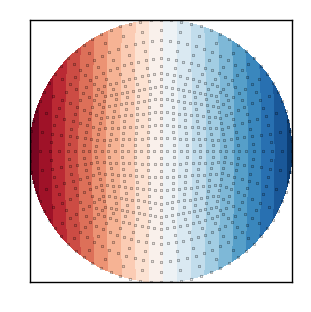

In [6]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# frequency index
i = 20

# ge the data
x = X[I_surface,0]
y = X[I_surface,1]
z = P[i,I_surface]

Pmax = np.max(np.abs(z))

fig,ax=plt.subplots()
lvls = np.linspace(-Pmax,Pmax,21)
#tri = ax.tricontour(x, y, z, levels=lvls, linewidths=0.5, colors='k')
cnt = ax.tricontourf(x, y, z.real, levels=lvls, cmap="RdBu_r")
#cnt.set_array(np.abs(P[0,I_surface]))
#cbar = fig.colorbar(cnt, ax=ax)
#cbar.set_label('Pressure in Pa', rotation=270)
ax.set_xticks([])
ax.set_yticks([])
ax.plot(x, y, 'ko', ms=0.1)
ax.set_aspect('equal')
#ax.set_title('Surface pressure in Pa')
fig.tight_layout()

# the animation update function
N = 25 # frames of the animation
def animate(n):
    zn = np.real( z*np.exp(2j*np.pi*n/N) )
    # delete old contours
    global cnt
    for c in cnt.collections:
        c.remove()
    # re-create
    cnt = ax.tricontourf(x, y, zn, levels=lvls, cmap="RdBu_r")
    return cnt

# do the animation
anim = FuncAnimation(fig, animate, frames=N, interval=100)
name = 'surface-pitch_%.2fHz.gif'%(f[i])
anim.save(name, writer='imagemagick', fps=20)

In [7]:
# show it in the notebook, commented out to keep notebook file short
# HTML(anim.to_jshtml())

Here is the response at at 2.1Hz

![a](surface-pitch_2.10Hz.gif)

Plotting the surface pressure, which is proportional to the surface elevation, at the line $y=0$ is also possible

Text(0, 0.5, 'Pressure in Pa')

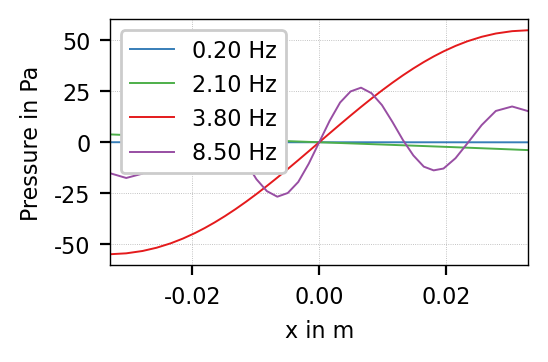

In [8]:
# select and sort
I_0 = np.argwhere(np.abs(X[I_surface,1])<0.0001).ravel() # indices of the surface points with y = 0
I_s = np.argsort(X[I_surface,0][I_0]).ravel() # sorting indices
I_0 = I_0[I_s]

# extract data
x_0 = X[I_surface,0][I_0]
P_0 = P[:,I_surface][:,I_0]

# plot for selected frequencies
If = np.array([1,20,37,84])
fig,ax=plt.subplots()
ax.plot(x_0, P_0[If,:].real.T, ms=0.1)
ax.legend(['%.2f Hz'%(val) for val in f[If]])
ax.set_xlabel('x in m')
ax.set_xlim([x_0.min(),x_0.max()])
ax.set_ylabel('Pressure in Pa')

### Comparision and Control

What is the optimal pitch value such that for a given sway amplitude there is no surface displacement?

The surface response for forced (pure) sway was computed above.
It can be described by the transfer function 

$$
H_u = \frac{\hat{\eta}_u}{\hat{u}}
$$

where $\hat{u}$ denotes the sway excitation.
The surface response amplitude $\hat{\eta}$ can be given at an arbitrary point, or as an average measure to be determined.
Simularly we have determined the pitch response by above computation

$$
H_\beta = \frac{\hat{\eta}_\beta}{\hat{\beta}}
$$

where $\hat{\beta}$ is the prescribed pitch amplitude.

Let's compare both transfer functions.
Note that the reference sway amplitude was 1cm and the reference pitch angle was 1deg.

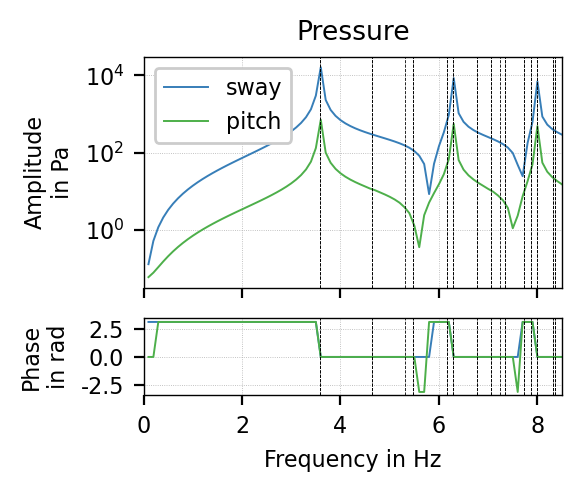

In [9]:
P_pitch = get_result('results_hdf5/Forced_Pitch.cfs','waterPressure',step='all')
P_sway = get_result('results_hdf5/Forced_Sway.cfs','waterPressure',step='all')

fig,axs=plt.subplots(nrows=2,figsize=[2.7,2.2], gridspec_kw={'height_ratios': [3, 1]})
ax = axs[0]
#ax.semilogy(f,np.max(np.abs(P[:,I_surface]),axis=1),'k',label='max' )
ax.semilogy(f,np.abs(P_sway[:,I_left]),label='sway' )
ax.semilogy(f,np.abs(P_pitch[:,I_left]),label='pitch' )

#ax.semilogy(f,np.abs(P[:,I_right]),label='right' )
ax.set_ylabel('Amplitude\nin Pa')
ax.set_title('Pressure')

ax = axs[1]
ax.plot(f,np.angle(P_sway[:,I_left]),label='sway' )
ax.plot(f,np.angle(P_pitch[:,I_right]),label='pitch' )
ax.set_ylabel('Phase\nin rad')


axs[-1].set_xlabel('Frequency in Hz')
axs[0].legend()
axs[0].set_xticklabels([])

#ax.set_ylim(ax.get_ylim())
for ax in axs:
    ax.set_xlim(0,f[-1])
    lim = ax.get_ylim()
    ax.set_ylim(lim)
    ax.vlines(f_eigen,*lim,lw=0.3,color='k',ls='--');

Based on the know surface displacement transfer functions we can now compute the required pitch control.
For this we define the mean surface pressure on one side (left) of the glass as a measure for the surface displacement.
Since we are dealing with linear systems the total surface displacement is a linear superposition of both load cases,
and we require it to be zero, i.e.

$$
\hat{\eta} = \hat{\eta}_u + \hat{\eta}_\beta = 0
$$

thus, using the tranfer functions we can compute the required pitch angle from 

$$
\hat{\beta} = -\frac{ H_u }{H_\beta} \hat{u}
$$

Of course one obtains differnt results if a different measure for the surface displacment is taken.
Below we plot the result for mean (as above) and the left and right most points on the surface, respectively.

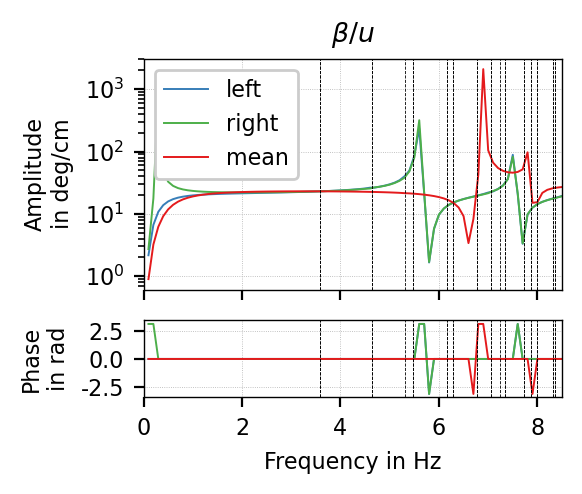

In [10]:
# copute the pitch control
I_surfleft= I_surface[np.argwhere(X[I_surface,0]<=0).ravel()]
H_sway = np.mean(P_sway[:,I_surfleft],axis=1)
H_pitch = np.mean(P_pitch[:,I_surfleft],axis=1)
pitch_control = -H_sway/H_pitch

# plot
fig,axs=plt.subplots(nrows=2,figsize=[2.7,2.2], gridspec_kw={'height_ratios': [3, 1]})

# amplitude
ax = axs[0]
ax.plot(f,np.abs((-P_sway/P_pitch)[:,I_left]),label='left' )
ax.plot(f,np.abs((-P_sway/P_pitch)[:,I_right]),label='right' )
ax.semilogy(f,np.abs(pitch_control),label='mean' )
ax.set_ylabel('Amplitude\nin deg/cm')
ax.set_title('$\\beta/u$')

# phase
ax = axs[1]
ax.plot(f,np.angle((-P_sway/P_pitch)[:,I_left]),label='left' ) 
ax.plot(f,np.angle((-P_sway/P_pitch)[:,I_right]),label='right' )
ax.plot(f,np.angle(pitch_control),label='mean' )
ax.set_ylabel('Phase\nin rad')

# cosmetics
axs[-1].set_xlabel('Frequency in Hz')
axs[0].legend()
axs[0].set_xticklabels([])
for ax in axs:
    ax.set_xlim(0,f[-1])
    lim = ax.get_ylim()
    ax.set_ylim(lim)
    ax.vlines(f_eigen,*lim,lw=0.3,color='k',ls='--'); # modes

Now we sace the result to text files to use in a validation computation with CFS.
The same result could be obtained by linear superposition of the results from pitch and sway case.

In [11]:
np.savetxt('control_value.dat',np.vstack([f,np.abs(pitch_control)]).T,fmt='%.6e')
np.savetxt('control_angle.dat',np.vstack([f,np.angle(pitch_control)]).T,fmt='%.6e')
np.savetxt('control_real.dat',np.vstack([f,np.real(pitch_control)]).T,fmt='%.6e')
np.savetxt('control_imag.dat',np.vstack([f,np.imag(pitch_control)]).T,fmt='%.6e')

The results are obtained from the input file [`Forced_control.xml`](Forced_control.xml).
We compare the response (maximum pressure) from the original sway case and the controlled one.

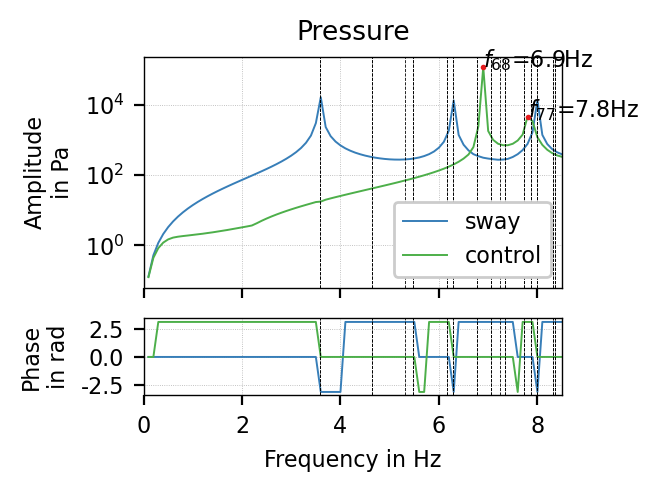

In [12]:
P_sway = get_result('results_hdf5/Forced_Sway.cfs','waterPressure',step='all')
P_swayControl = get_result('results_hdf5/Forced_control.cfs','waterPressure',step='all')

fig,axs=plt.subplots(nrows=2,figsize=[2.7,2.2], gridspec_kw={'height_ratios': [3, 1]})
ax = axs[0]
ax.semilogy(f,np.max(np.abs(P_sway[:,I_surface]),axis=1),label='sway' )
ax.semilogy(f,np.max(np.abs(P_swayControl[:,I_surface]),axis=1),label='control' )
ax.set_ylabel('Amplitude\nin Pa')
ax.set_title('Pressure')

from scipy.signal import find_peaks
y = np.max(np.abs(P_swayControl[:,I_surface]),axis=1)
Ip,_ = find_peaks( y )
ax.semilogy(f[Ip],y[Ip],'o',ms=1)
for i in Ip:
    ax.annotate('$f_{%i}$=%.1fHz'%(i,f[i]),(f[i],y[i]))

ax = axs[1]
ax.plot(f,np.angle(P[:,I_left]),label='left' )
ax.plot(f,np.angle(P[:,I_right]),label='right' )
ax.set_ylabel('Phase\nin rad')


axs[-1].set_xlabel('Frequency in Hz')
axs[0].legend()
axs[0].set_xticklabels([])

#ax.set_ylim(ax.get_ylim())
for ax in axs:
    ax.set_xlim(0,f[-1])
    lim = ax.get_ylim()
    ax.set_ylim(lim)
    ax.vlines(f_eigen,*lim,lw=0.3,color='k',ls='--');

Clearly the the control works well, reducing the pressure up to several orders of magnitide.
Especially first and second mode can be supressed.
However, there are some new peaks at higher frequencies (above 6 Hz).
Let's see how the response looks like for those peaks.

![surface-control-peak_6.90Hz.gif](surface-control-peak_6.90Hz.gif)
![surface-control-peak_7.80Hz.gif](surface-control-peak_7.80Hz.gif)


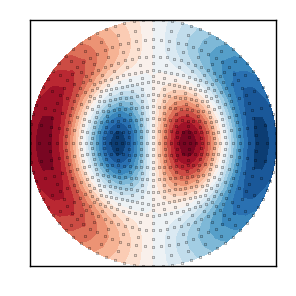

In [13]:
i = Ip[1]
anims = []
for i in Ip:
    # ge the data
    x = X[I_surface,0]
    y = X[I_surface,1]
    z = P_swayControl[i,I_surface]

    Pmax = np.max(np.abs(z))

    fig,ax=plt.subplots()
    lvls = np.linspace(-Pmax,Pmax,21)
    #tri = ax.tricontour(x, y, z, levels=lvls, linewidths=0.5, colors='k')
    cnt = ax.tricontourf(x, y, z.real, levels=lvls, cmap="RdBu_r")
    #cnt.set_array(np.abs(P[0,I_surface]))
    #fig.colorbar(cnt, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(x, y, 'ko', ms=0.1)
    ax.set_aspect('equal')

    # the animation update function
    N = 25 # frames of the animation
    def animate(n):
        zn = np.real( z*np.exp(2j*np.pi*n/N) )
        # delete old contours
        global cnt
        for c in cnt.collections:
            c.remove()
        # re-create
        cnt = ax.tricontourf(x, y, zn, levels=lvls, cmap="RdBu_r")
        return cnt

    # do the animation
    anim = FuncAnimation(fig, animate, frames=N, interval=100)
    # save in list
    anims.append(anim)
    # export gif
    name = 'surface-control-peak_%.2fHz.gif'%(f[i])
    anim.save(name, writer='imagemagick', fps=20)
    print('![%s](%s)'%(name,name))
# no

In [14]:
# show animation in the notebook (commented out to avoid long text in notebook)
# HTML(anims[0].to_jshtml())

Clearly there are some modes that cannot be supressed by pitch control.

![surface-control-peak_6.90Hz.gif](surface-control-peak_6.90Hz.gif)
![surface-control-peak_7.80Hz.gif](surface-control-peak_7.80Hz.gif)

References
----------

[^1]: Toth, F., and Kaltenbacher, M. (2016) Fully coupled linear modelling of incompressible free-surface flow, compressible air and flexible structures. Int. J. Numer. Meth. Engng, 107: 947– 969. [doi: 10.1002/nme.5194](https://doi.org/10.1002/nme.5194).




 